## Setting up the environment

In [1]:
%%capture
files = !ls
files = [f.split("  ") for f in files][0]

isFRIQML = 'fri_qml' in files
isFRIQMLPath = isFRIQML and "setup.py" in files

# Clone the entire repo. Only run once!
if not isFRIQML:
  !git clone -l -s https://github.com/znajob/fri_qml.git fri_qml

if not isFRIQMLPath:
  %cd fri_qml

!git pull
!pip install -e .

In [2]:
# MAIN IMPORTS
import pennylane as qml
from pennylane import numpy as np
from friqml.visualisation import plot_quantum_state, plot_histogram
from friqml.utils import eps, random_state_normalized, random_state_unnormalized
from functools import partial
from tqdm.notebook import tqdm
from friqml.utils import eps
import matplotlib.pyplot as plt

When solving the exercises refer to the [PennyLane documentation](https://pennylane.readthedocs.io/en/stable/).

## Grover search
Exercises are based on https://pennylane.ai/qml/demos/tutorial_grovers_algorithm

### Exercise 1

Write a template `equal_superposition` that transforms the desired states into an equal superposition of the basis states. The argument `wires` contains the list of wires that should be transformed from the initial state to an equal superposition.

In [3]:
NUM_QUBITS = 2
dev = qml.device("default.qubit", wires=NUM_QUBITS)
wires = list(range(NUM_QUBITS))

In [ ]:
def equal_superposition(wires):
    for w in wires:
        qml.Hadamard(wires=w)

In [ ]:
@qml.qnode(dev)
def circuit():
    # Remove the commented snapshots to see the intermediate state of the system
    qml.Snapshot("Initial state")
    equal_superposition(wires)
    qml.Snapshot("After applying the Hadamard gates")
    return qml.probs(wires=wires)  # Probability of finding a computational basis state on the wires

results = qml.snapshots(circuit)()

for k, result in results.items():
     print(f"{k}: {result}")

In [7]:
# TEST
np.allclose(1,(results['execution_results']*(2**NUM_QUBITS)))

True

### Exercise 2
We will model the action of the oracle on the qubits with a `qml.FlipSign` function that flips the sign of a desired basis state. Implement a template `oracle(wires,omega)` where wires denote the qubits on which the template acts and omega the selected basis state.

In [ ]:
def oracle(wires, omega):
    qml.FlipSign(omega, wires=wires)

In [ ]:
omega = np.zeros(NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Before querying the Oracle")

    oracle(wires, omega)
    qml.Snapshot("After querying the Oracle")

    return qml.probs(wires=wires)

results = qml.snapshots(circuit)()

for k, result in results.items():
     print(f"{k}: {result}")

In [11]:
# TESTS
y2 = np.real(results["After querying the Oracle"])
print(np.allclose(1,(results['execution_results']*(2**NUM_QUBITS))))
print(np.allclose(y2[0],-0.5))
print(np.allclose(y2[1:],0.5))

True
True
True


### Exercise 3
Write a template `diffusion_operator_two_qubits(wires)` that implements the reflection around the uniform superposition all possible states on two qubits defined by the argument `wires`. The two qubit Grover diffusion operator can be implemented with the circuit below.

diffusion_2_qubits.svg

In [ ]:
###
### YOUR CODE HERE
###
def diffusion_operator_two_qubits(wires):
    qml.Hadamard(wires=[0])
    qml.Hadamard(wires=[1])
    qml.PauliX(wires=[0])
    qml.PauliX(wires=[1])
    #qml.ControlledQubitUnitary(qml.PauliZ, control_wires=wires[0], wires=wires[1])
    qml.ctrl(qml.PauliZ, wires[0])(wires=wires[1])
    qml.PauliX(wires=[0])
    qml.PauliX(wires=[1])
    qml.Hadamard(wires=[0])
    qml.Hadamard(wires=[1])
    qml.GlobalPhase(np.pi, wires=[0,1])

'''def diffusion_operator_two_qubits(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
        qml.PauliZ(wires=wire)
    qml.ctrl(qml.PauliZ, 0)(wires=1)
    for wire in wires:
        qml.Hadamard(wires=wire)'''



In [ ]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Uniform superposition |s>")

    oracle(wires, omega)
    qml.Snapshot("State marked by Oracle")
    diffusion_operator_two_qubits(wires)

    qml.Snapshot("Amplitude after diffusion")
    return qml.probs(wires=wires)


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

In [19]:
# TESTS
print(np.allclose(1,(results['execution_results'][0])))
print(np.allclose(1,(results['Amplitude after diffusion'][0])))
print(np.allclose(0,(results['Amplitude after diffusion'][1:])))


True
True
True


### Exercise 4

Write a template `diffusion_operator(wires)` that implements a general reflection around the uniform superposition all possible states on qubits defined by the argument `wires`. The Grover operator can be implemented with the following circuit

diffusion_n_qubits.svg

In [ ]:
def diffusion_operator(wires):
    ctrl_values = [0] * (len(wires) - 1)

    for wire in wires[:-1]:
        qml.Hadamard(wire)

    qml.PauliZ(wires[-1])
    qml.MultiControlledX(
        control_values=ctrl_values,
        wires=wires)

    qml.PauliZ(wires[-1])

    for wire in wires[:-1]:
        qml.Hadamard(wire)

    qml.GlobalPhase(np.pi, wires)

In [ ]:
NUM_QUBITS = 4
omega = [np.zeros(NUM_QUBITS)]

M = len(omega)
N = 2**NUM_QUBITS
wires = list(range(NUM_QUBITS))


dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    iterations = int(np.round(np.sqrt(N / M) * np.pi / 4))

    # Initial state preparation
    equal_superposition(wires)

    # Grover's iterator
    for _ in range(iterations):
        for omg in omega:
            oracle(wires, omg)
        # qml.templates.GroverOperator(wires)
        # The diffusion operator from the solution should have the same effect as the
        # commented line for the build-in template GroverOperator.
        diffusion_operator(wires)
    return qml.probs(wires=wires)

results = qml.snapshots(circuit)()

for k, result in results.items():
     print(f"{k}: {result}")

In [22]:
# TESTS
print(results['execution_results'][0]>0.9)

True


## Landau-Zener

### Exercise 1

In this exercise we will study the Landau-Zener problem and calculate the transition probability to an excited state

The Landau-Zener Hamiltonian is
$$
H(t) = \frac{1}{2} \begin{pmatrix} \epsilon(t) & \Delta \\
                                      \Delta & -\epsilon(t) \end{pmatrix}
$$

Where:
- $\epsilon(t) = vt$ is the detuning (changes linearly with time)
- $\Delta$ is the minimum energy gap
- $v$ is the sweeping rate

Write a function that solves the Schrödinger equation for the Landau-Zener problem. You can use the `solve_ivp` function from `scipy.integrate`. The function `transition_probability(T,v,Delta)` integrates the initial state $|0\rangle=(1,0)$ from time $-T$ until time $T$ with the above time-dependent Hamiltonian and returns probabilities to observe the state $|0\rangle=(1,0)$ and the state $|1\rangle=(0,1)$. The function should return also the corresponding times at which the probabilities are calculated.

In [ ]:
from scipy.integrate import solve_ivp


In [ ]:
def transition_probability(T, v, Delta):
    # Time-dependent Hamiltonian
    def H(t):
        eps = v * t
        return 0.5 * np.array([[eps, Delta], [Delta, -eps]])

    # Schrödinger equation: dψ/dt = -i H ψ
    def schrodinger(t, psi):
        return -1j * H(t).dot(psi)

    # Initial state: |0⟩ = [1, 0]
    psi0 = np.array([1.0, 0.0], dtype=complex)

    # Solve the time evolution
    t_span = (-T, T)
    t_eval = np.linspace(*t_span, 500)
    sol = solve_ivp(schrodinger, t_span, psi0,
                    t_eval=t_eval, rtol=1e-8, atol=1e-8)

    # Probabilities
    P0 = np.abs(sol.y[0])**2  # |⟨0|ψ(t)⟩|²
    P1 = np.abs(sol.y[1])**2  # |⟨1|ψ(t)⟩|²
    return t_eval, P0, P1

In [25]:
# Parameters
Delta = 2   # Minimum gap
v = 1.0       # Sweep velocity
T = 30        # Time span
t, P0_large, P1_large  = transition_probability(T,v,Delta)


# Parameters
Delta = 0.5   # Minimum gap
v = 1.0       # Sweep velocity
T = 10        # Time span
t, P0_small, P1_small  = transition_probability(T,v,Delta)


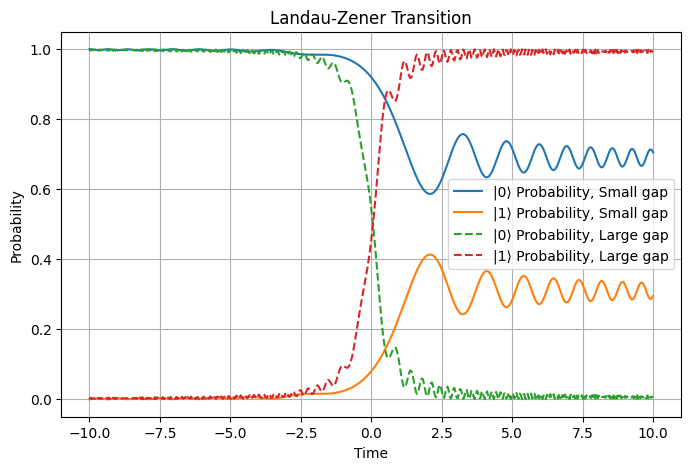

In [26]:
plt.figure(figsize=(8,5))
plt.plot(t, P0_small, label='|0⟩ Probability, Small gap')
plt.plot(t, P1_small, label='|1⟩ Probability, Small gap')

plt.plot(t, P0_large, label='|0⟩ Probability, Large gap',ls="--")
plt.plot(t, P1_large, label='|1⟩ Probability, Large gap',ls="--")
plt.title("Landau-Zener Transition")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from tqdm.notebook import tqdm

In [32]:
v = 1.0
T = 100
probability = []
deltas = np.arange(0.1, 2, 0.1)
for delta in tqdm(deltas):
  _, _, P1 = transition_probability(T, v, delta)
  probability.append(P1[-1])


  0%|          | 0/19 [00:00<?, ?it/s]

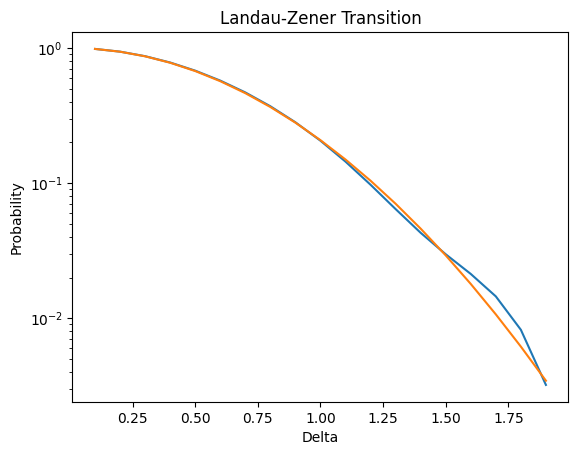

In [34]:
plt.plot(deltas, 1-np.array(probability))
plt.plot(deltas, np.exp(-np.pi/2*deltas**2))
plt.xlabel("Delta")
plt.ylabel("Probability")
plt.title("Landau-Zener Transition")
plt.yscale("log")
plt.show()